In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'HUN'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2014-03-31,2755,-2305,450,69,277,1691,1911,4228,130,...,9227,1185,0,270,2215,3626,7211,-67,-107,246
1,2014-06-30,2988,-2483,505,124,403,1819,1847,4448,130,...,9442,1162,0,257,2144,3814,7300,50,-107,246
2,2014-09-30,2884,-2369,515,194,582,1639,1788,4494,126,...,9409,1176,0,274,2122,3758,7190,360,-137,246
3,2014-12-31,2951,-2502,449,-34,860,1665,2025,5039,122,...,10923,1275,0,267,2332,4860,9168,417,-250,246
4,2015-03-31,2589,-2139,450,17,994,1633,1869,4887,119,...,10751,1191,0,529,2474,4835,9184,34,-149,245


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2022-12-31,2023-02-11,203,1650,-1460,190,-56,654,813,995,...,425,8220,961,0,66,1701,1671,4621,310,-86
36,2023-03-31,2023-04-21,177,1606,-1337,269,44,615,878,1048,...,415,7763,857,0,11,1297,1509,4023,-154,-46
37,2023-06-30,2023-07-21,177,1596,-1342,254,33,502,856,1012,...,406,7553,745,0,11,1176,1562,3969,36,-51
38,2023-09-30,2023-10-21,177,1506,-1275,231,15,496,822,941,...,395,7369,726,0,113,1271,1493,3970,163,-50
39,2023-12-31,2024-02-11,177,1403,-1251,152,-57,540,747,867,...,387,7248,719,0,12,1172,1676,4025,164,-83


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,203,1650,-1460,190,-56,654,813,995,...,8220,961,0,66,1701,1671,4621,310,-86,1
36,2023-03-31,2023-04-21,177,1606,-1337,269,44,615,878,1048,...,7763,857,0,11,1297,1509,4023,-154,-46,1
37,2023-06-30,2023-07-21,177,1596,-1342,254,33,502,856,1012,...,7553,745,0,11,1176,1562,3969,36,-51,1
38,2023-09-30,2023-10-21,177,1506,-1275,231,15,496,822,941,...,7369,726,0,113,1271,1493,3970,163,-50,1
39,2023-12-31,2024-02-11,177,1403,-1251,152,-57,540,747,867,...,7248,719,0,12,1172,1676,4025,164,-83,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,203,1650.0,-1460.0,190.0,-56.0,654.0,813.0,995.0,...,8220.0,961.0,0.0,66.0,1701.0,1671.0,4621.0,310.0,-86.0,1
36,2023-03-31,2023-04-21,177,1606.0,-1337.0,269.0,44.0,615.0,878.0,1048.0,...,7763.0,857.0,0.0,11.0,1297.0,1509.0,4023.0,-154.0,-46.0,1
37,2023-06-30,2023-07-21,177,1596.0,-1342.0,254.0,33.0,502.0,856.0,1012.0,...,7553.0,745.0,0.0,11.0,1176.0,1562.0,3969.0,36.0,-51.0,1
38,2023-09-30,2023-10-21,177,1506.0,-1275.0,231.0,15.0,496.0,822.0,941.0,...,7369.0,726.0,0.0,113.0,1271.0,1493.0,3970.0,163.0,-50.0,1
39,2023-12-31,2024-02-11,177,1403.0,-1251.0,152.0,-57.0,540.0,747.0,867.0,...,7248.0,719.0,0.0,12.0,1172.0,1676.0,4025.0,164.0,-83.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-04-21,18.432259,2014-03-31,2755.0,1.121951,8.195122,246.0,160.0,0.650407,277.0,...,0.218489,0.781511,6.516854,7.780591,39.783394,4.824699,0.163339,0.025045,0.029912,0.136905
1,2014-04-28,19.102112,2014-03-31,2755.0,1.121951,8.195122,246.0,160.0,0.650407,277.0,...,0.218489,0.781511,6.516854,7.780591,39.783394,4.824699,0.163339,0.025045,0.029912,0.136905
2,2014-05-05,18.936531,2014-03-31,2755.0,1.121951,8.195122,246.0,160.0,0.650407,277.0,...,0.218489,0.781511,6.516854,7.780591,39.783394,4.824699,0.163339,0.025045,0.029912,0.136905
3,2014-05-12,18.966633,2014-03-31,2755.0,1.121951,8.195122,246.0,160.0,0.650407,277.0,...,0.218489,0.781511,6.516854,7.780591,39.783394,4.824699,0.163339,0.025045,0.029912,0.136905
4,2014-05-19,20.231077,2014-03-31,2755.0,1.121951,8.195122,246.0,160.0,0.650407,277.0,...,0.218489,0.781511,6.516854,7.780591,39.783394,4.824699,0.163339,0.025045,0.029912,0.136905


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-04-21,18.432259,2014-03-31,2755.0,1.121951,8.195122,246.0,160.0,0.650407,277.0,...,4.824699,0.163339,0.025045,0.029912,0.136905,16.428752,2.249174,0.411464,1.040684,28.339598
1,2014-04-28,19.102112,2014-03-31,2755.0,1.121951,8.195122,246.0,160.0,0.650407,277.0,...,4.824699,0.163339,0.025045,0.029912,0.136905,17.025795,2.330912,0.426417,1.055637,29.369497
2,2014-05-05,18.936531,2014-03-31,2755.0,1.121951,8.195122,246.0,160.0,0.650407,277.0,...,4.824699,0.163339,0.025045,0.029912,0.136905,16.878212,2.310708,0.422721,1.051941,29.114917
3,2014-05-12,18.966633,2014-03-31,2755.0,1.121951,8.195122,246.0,160.0,0.650407,277.0,...,4.824699,0.163339,0.025045,0.029912,0.136905,16.905042,2.314381,0.423393,1.052613,29.161198
4,2014-05-19,20.231077,2014-03-31,2755.0,1.121951,8.195122,246.0,160.0,0.650407,277.0,...,4.824699,0.163339,0.025045,0.029912,0.136905,18.032047,2.468673,0.451619,1.080839,31.105281


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

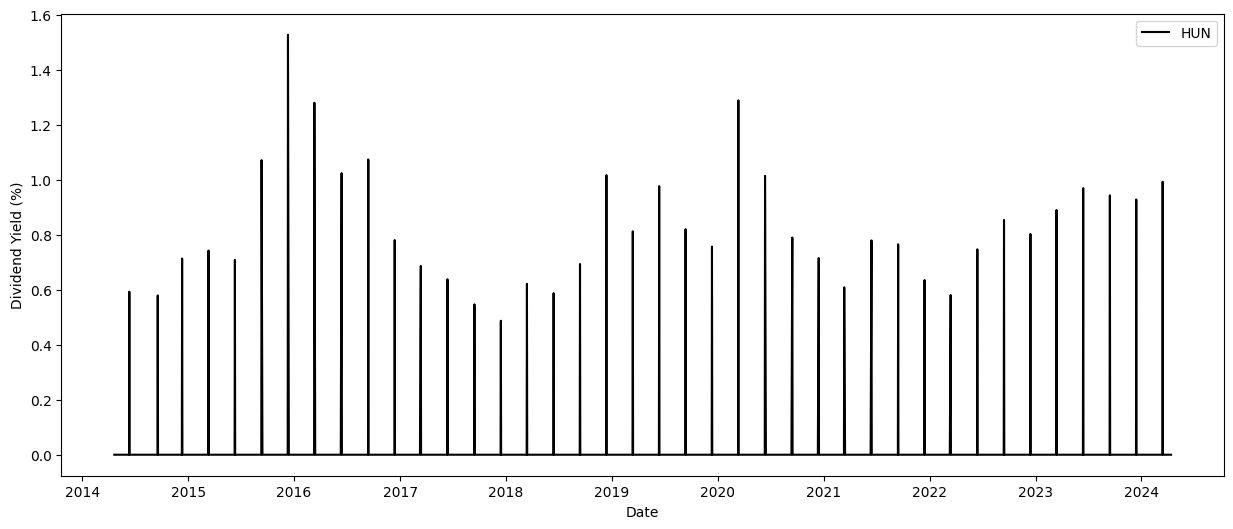

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


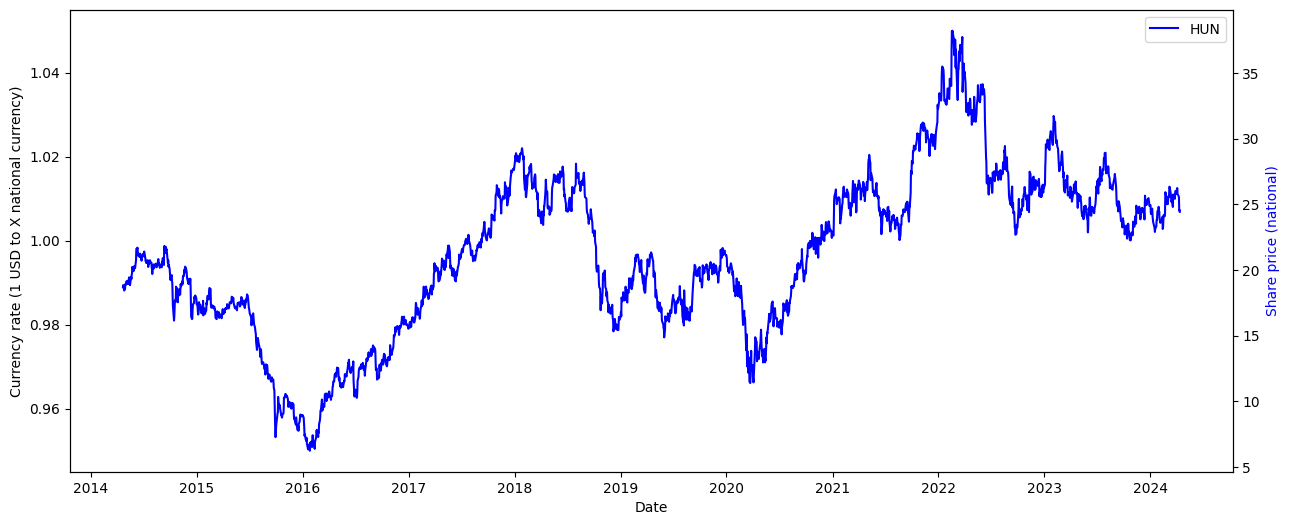

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

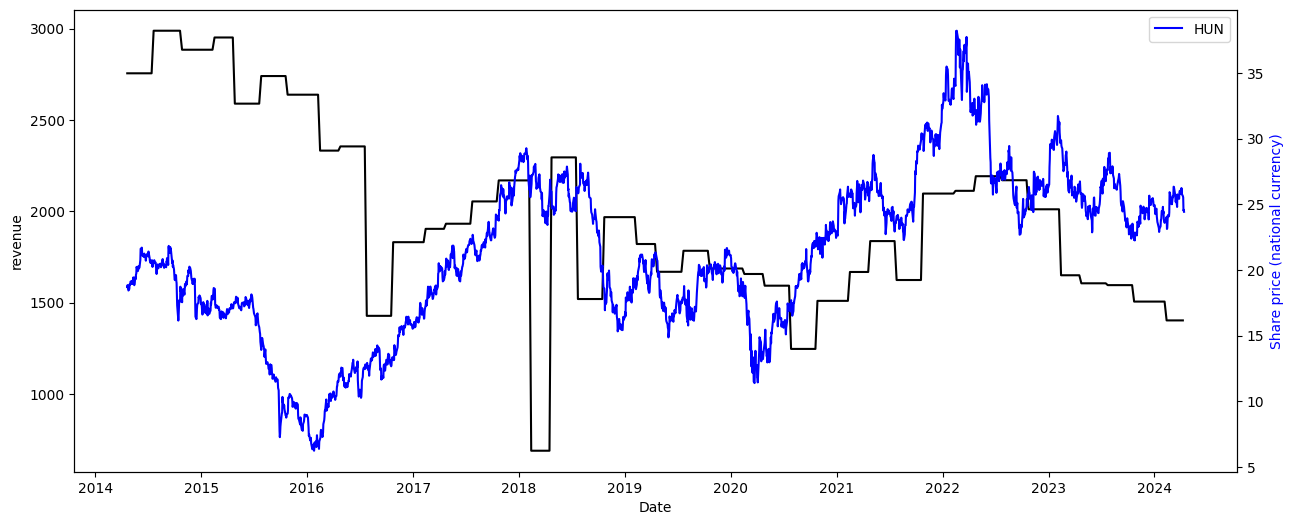

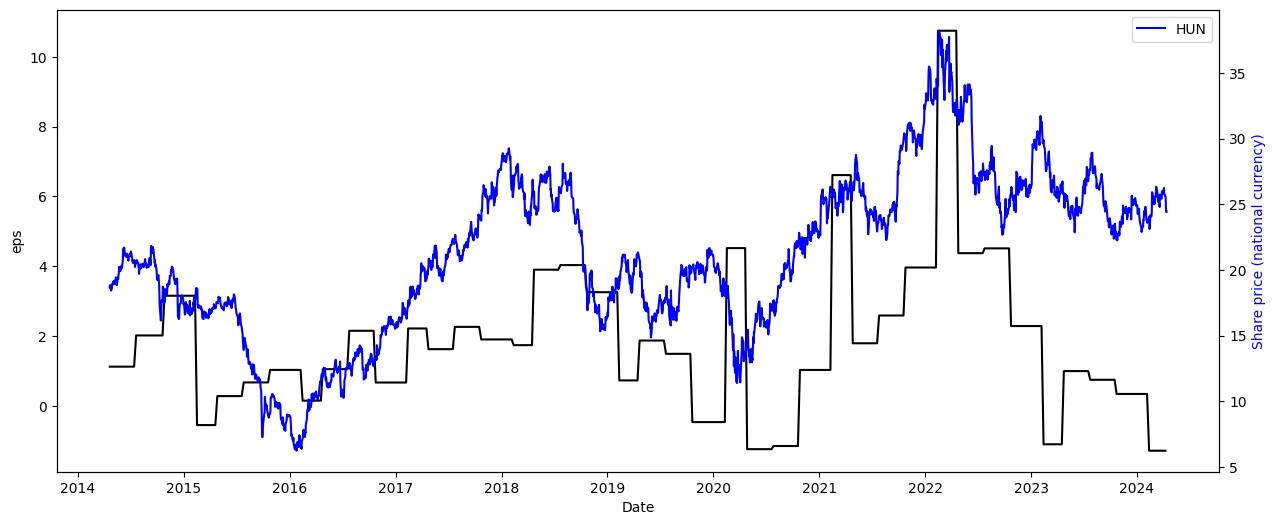

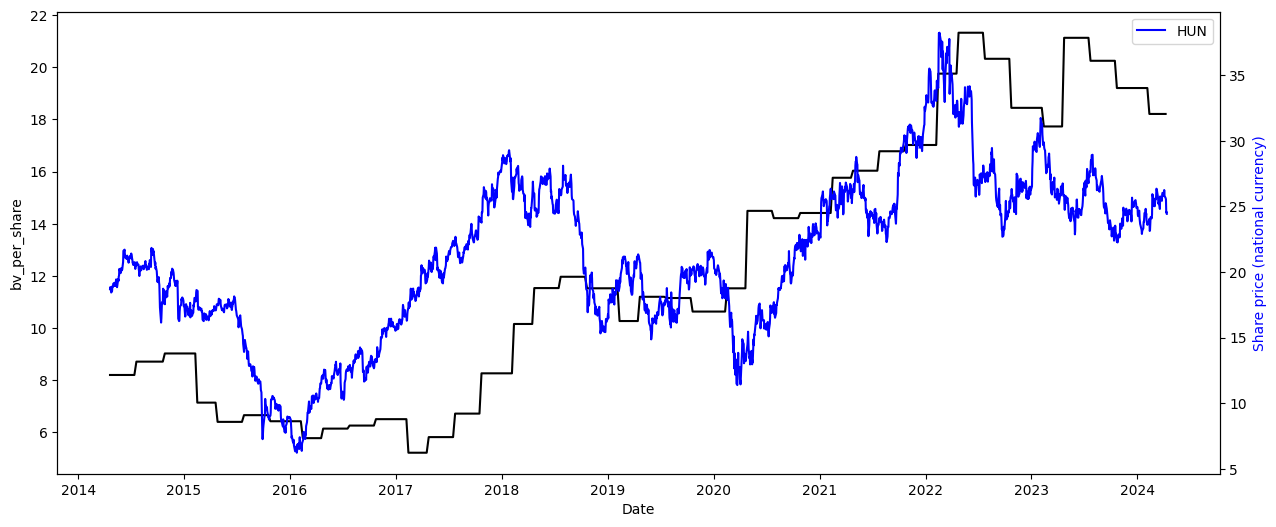

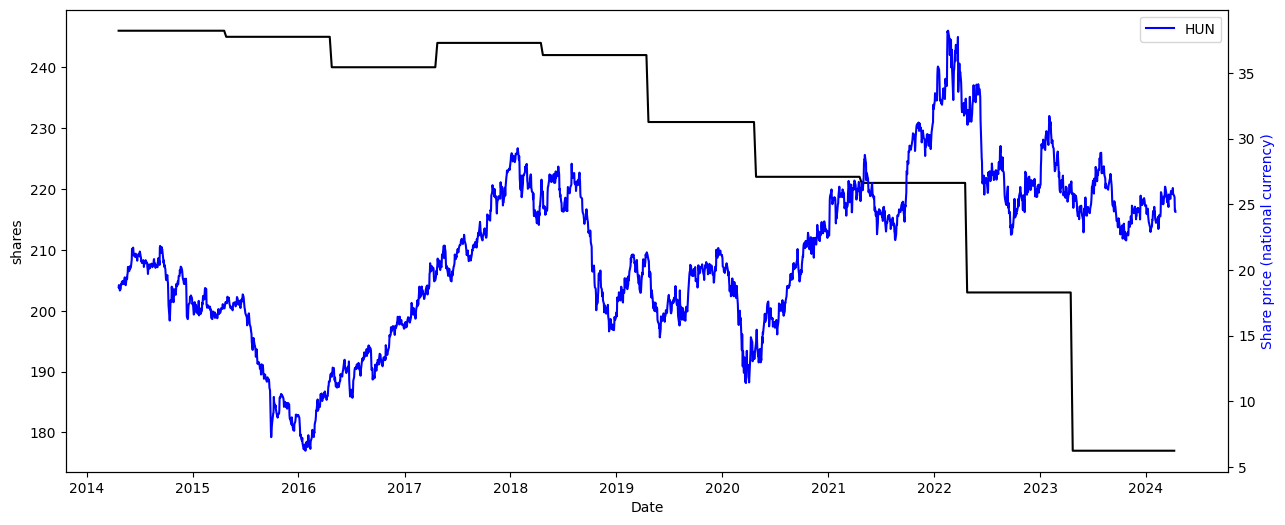

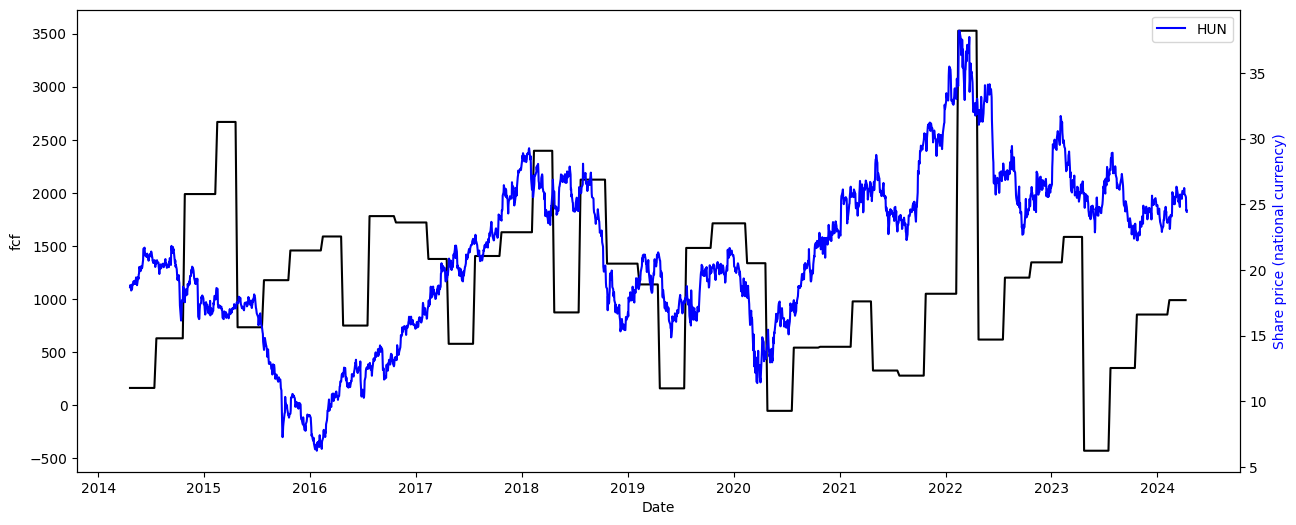

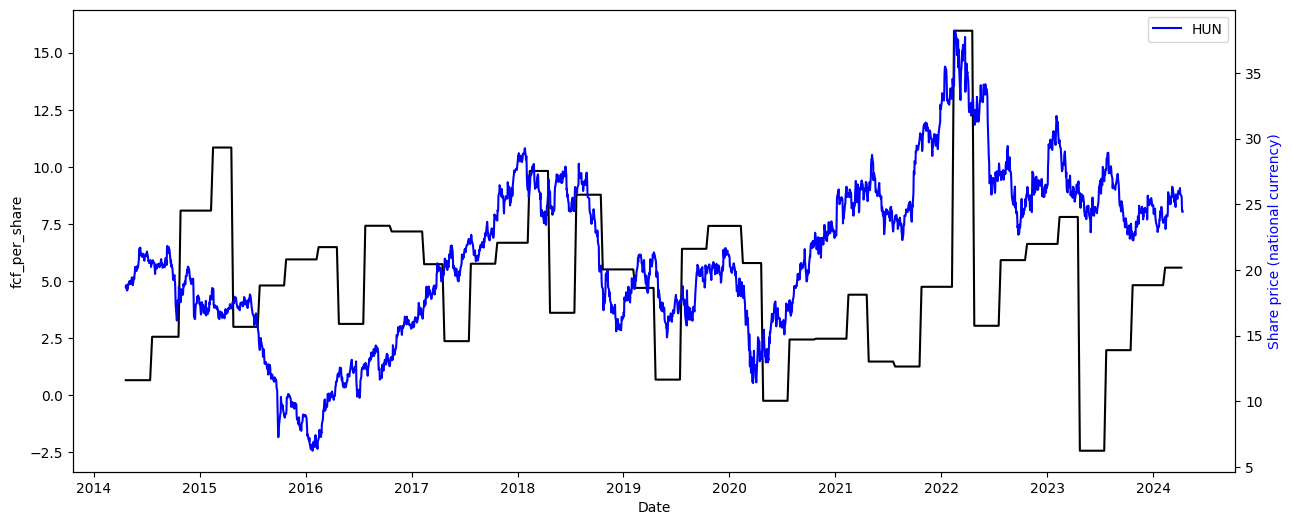

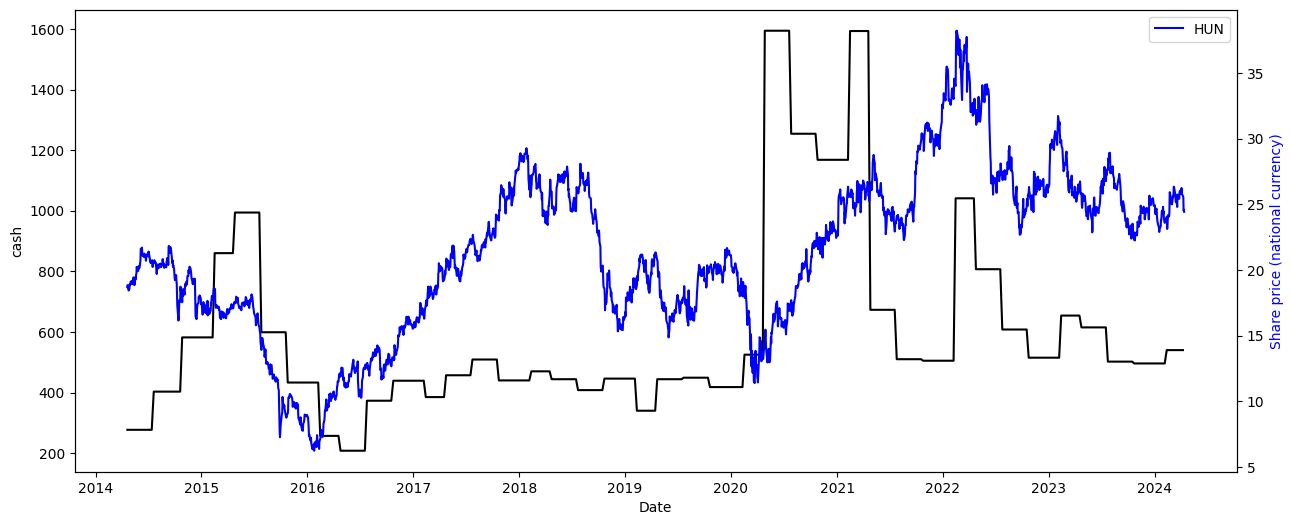

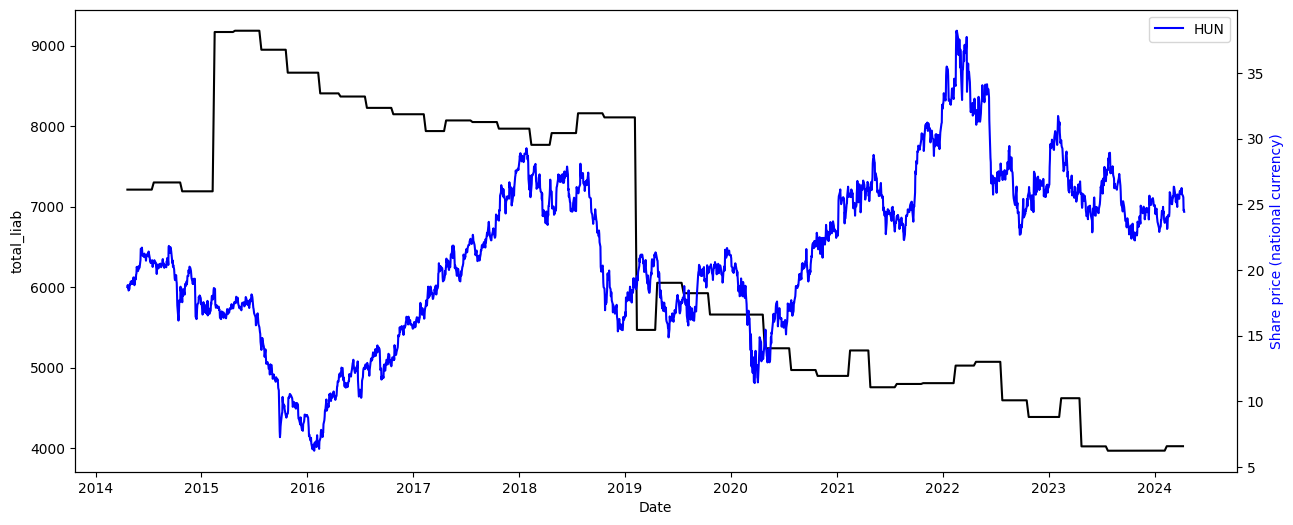

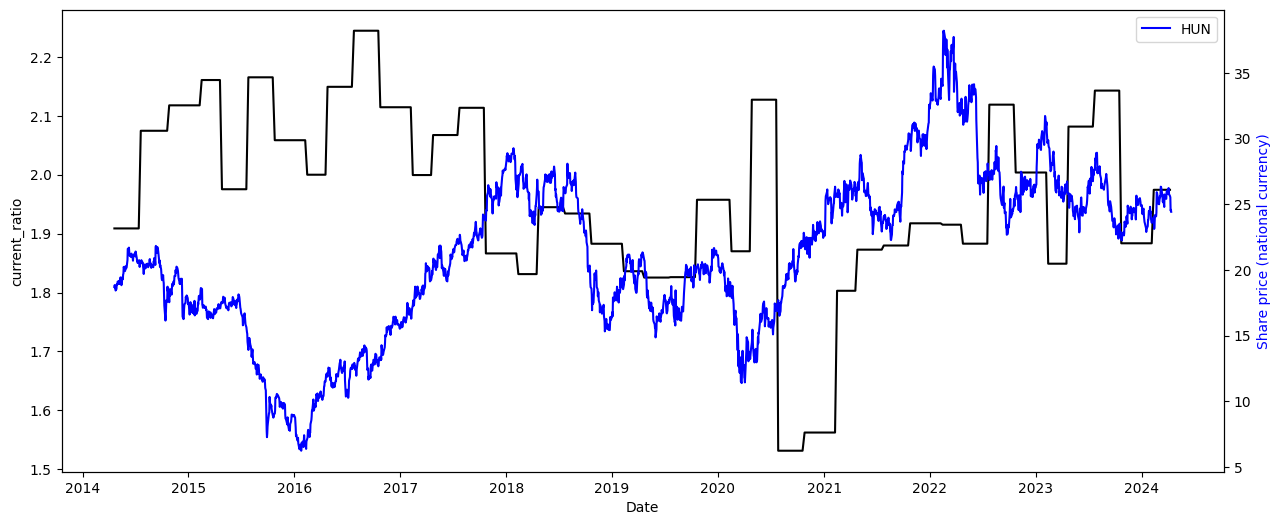

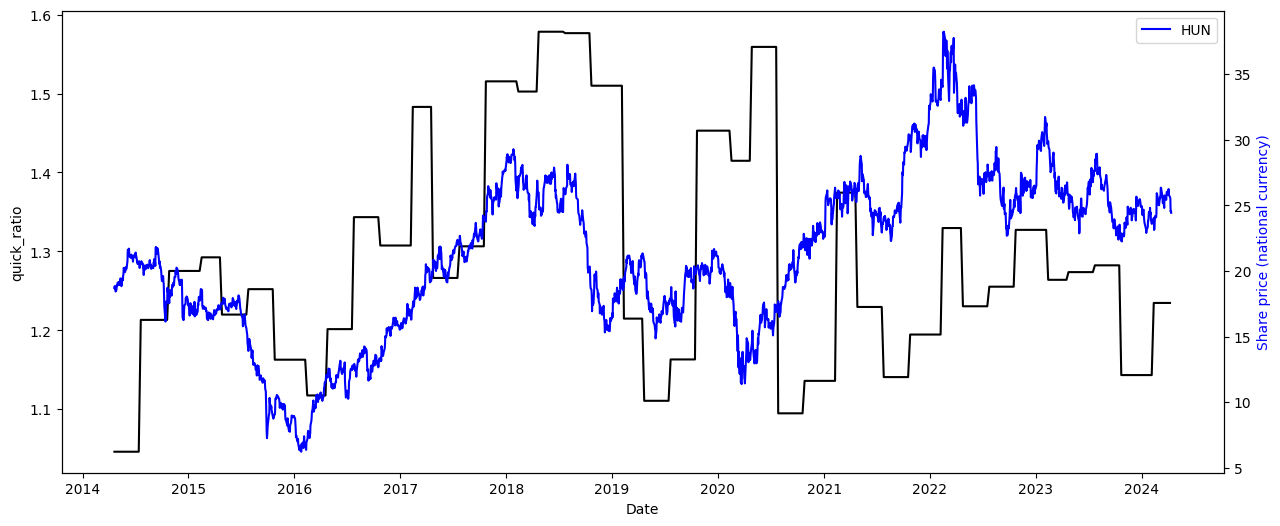

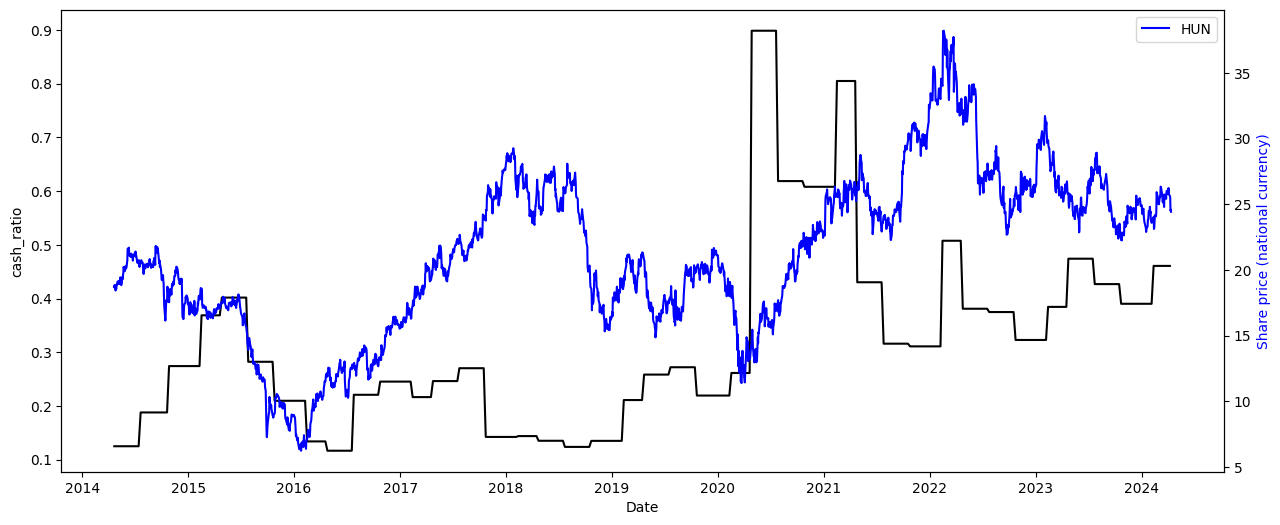

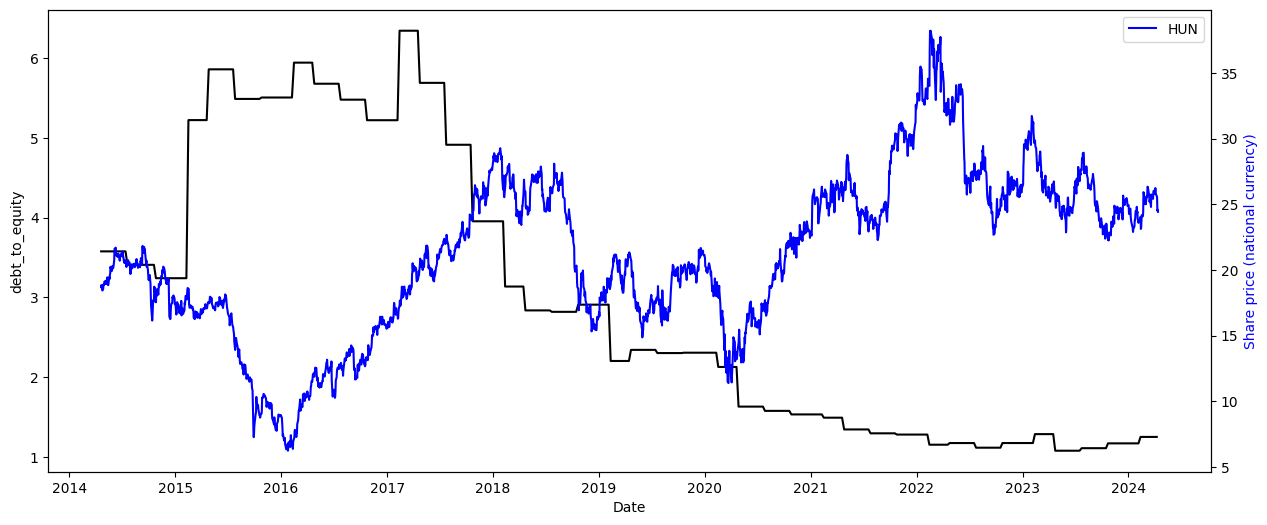

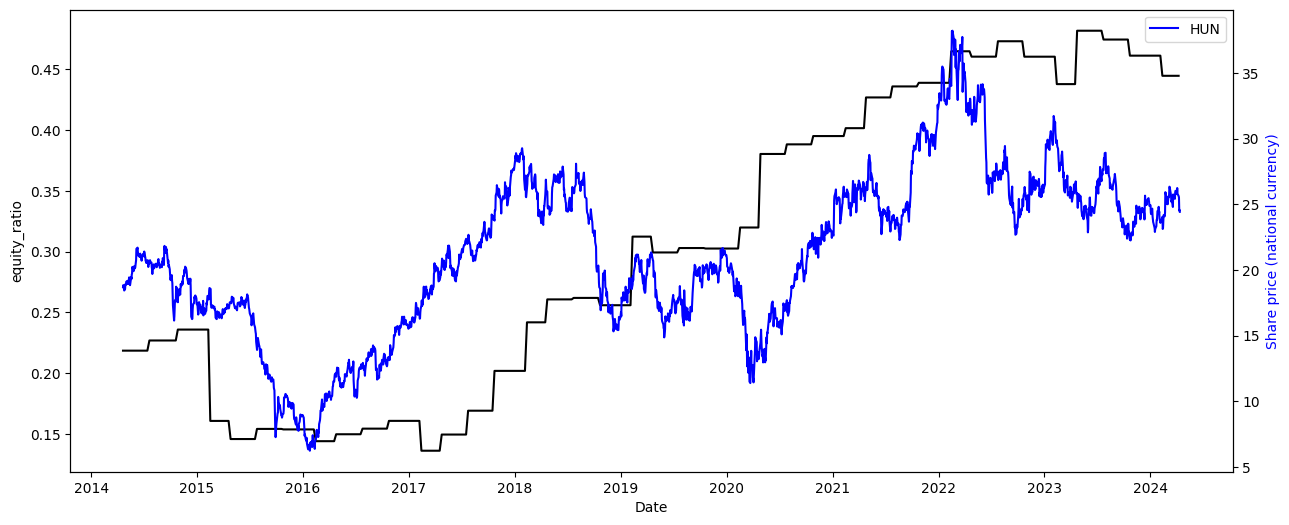

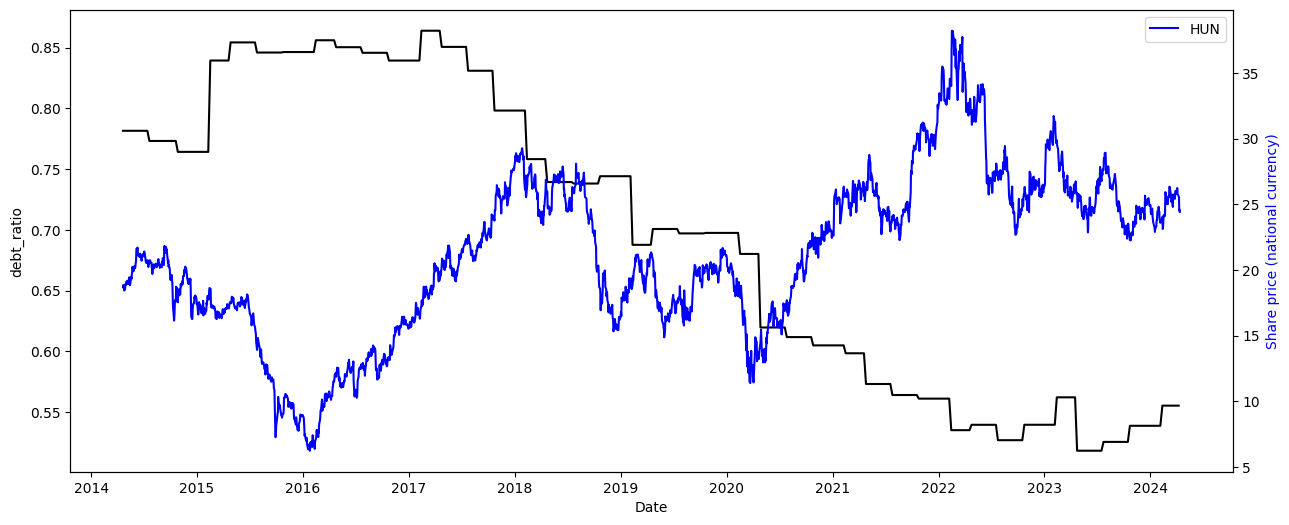

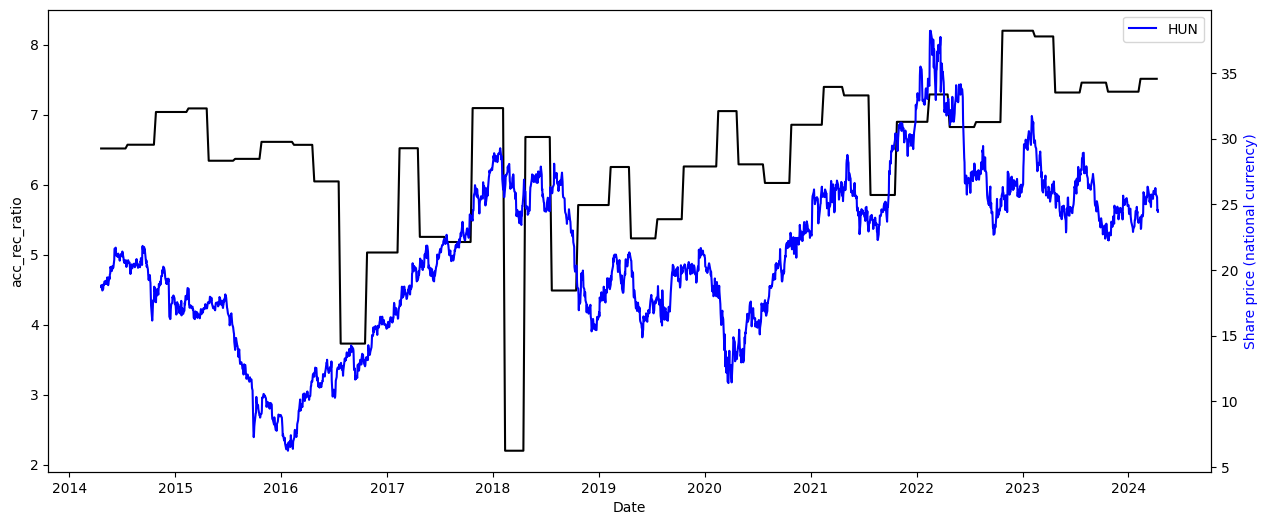

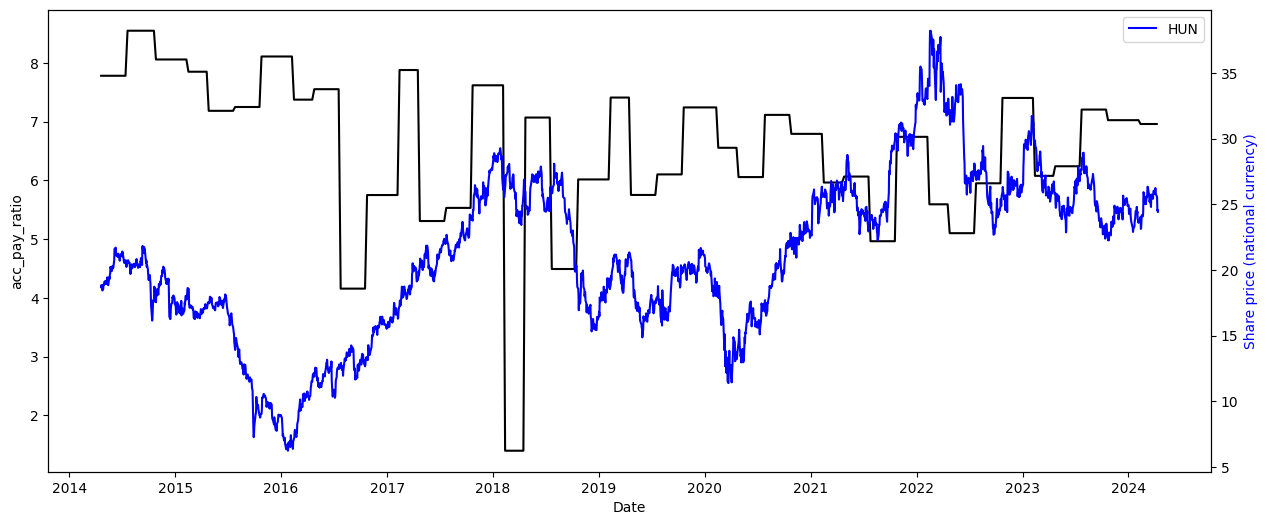

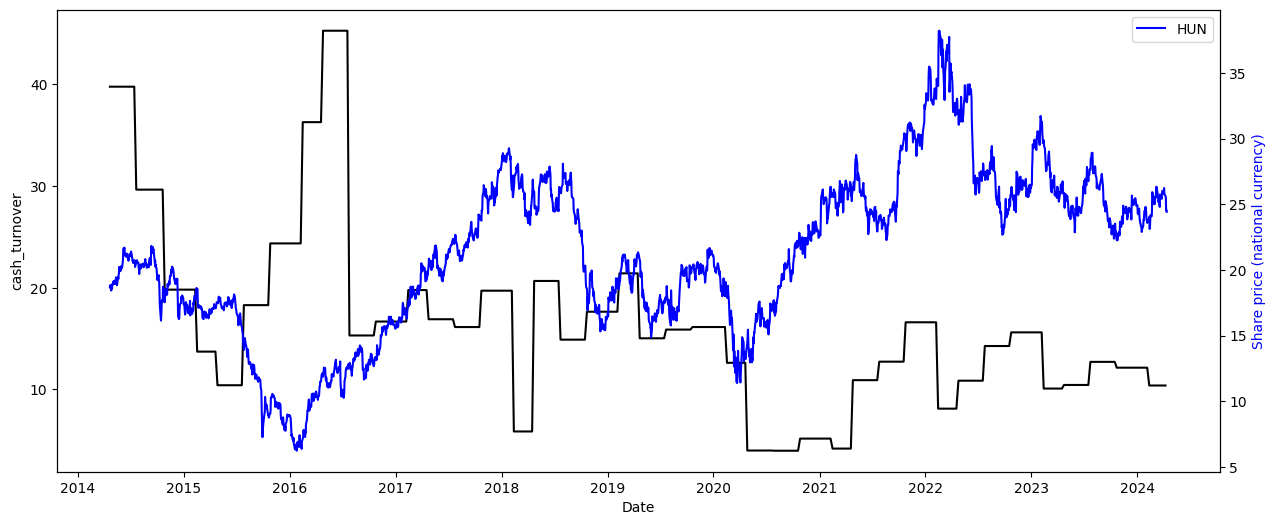

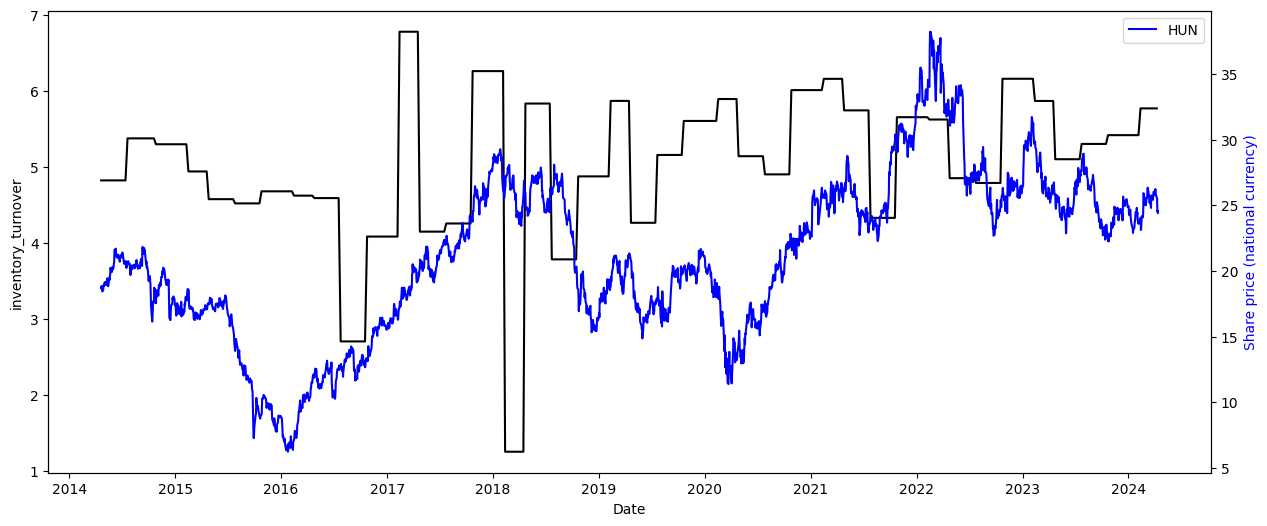

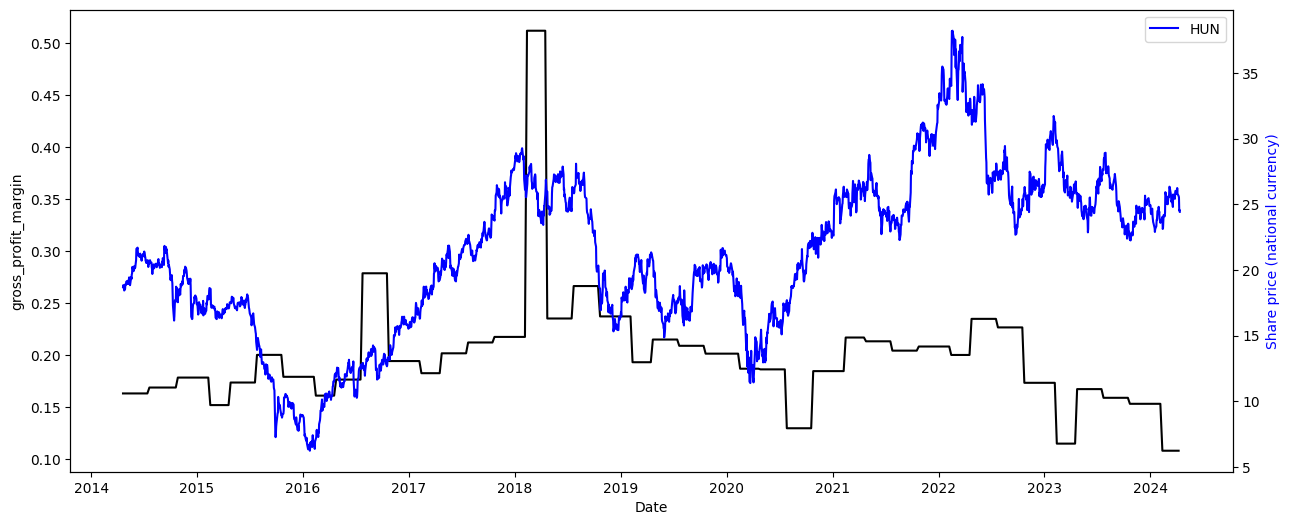

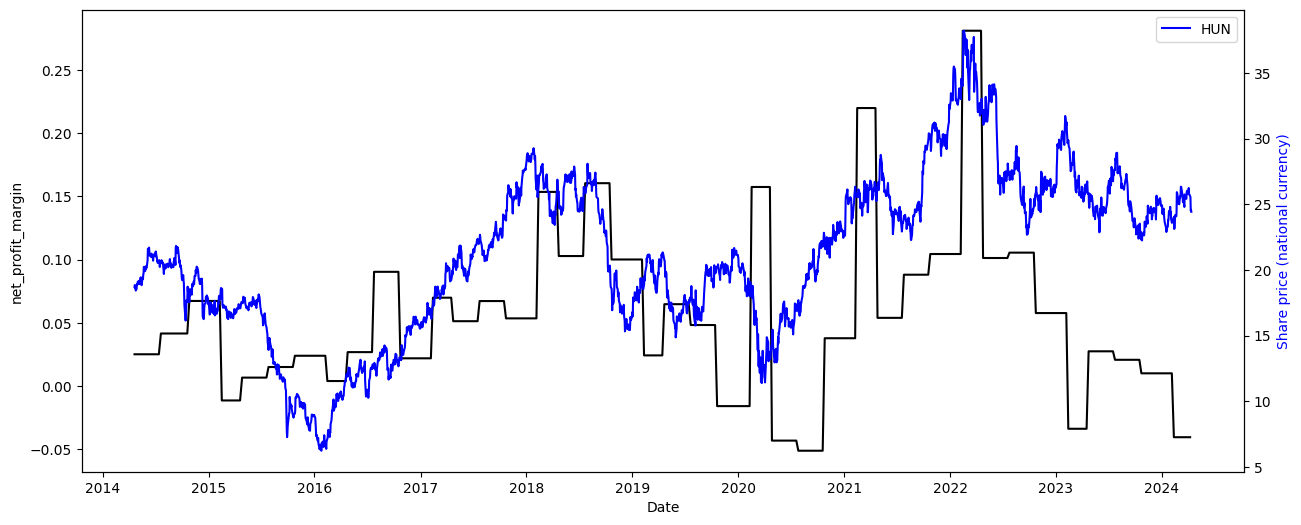

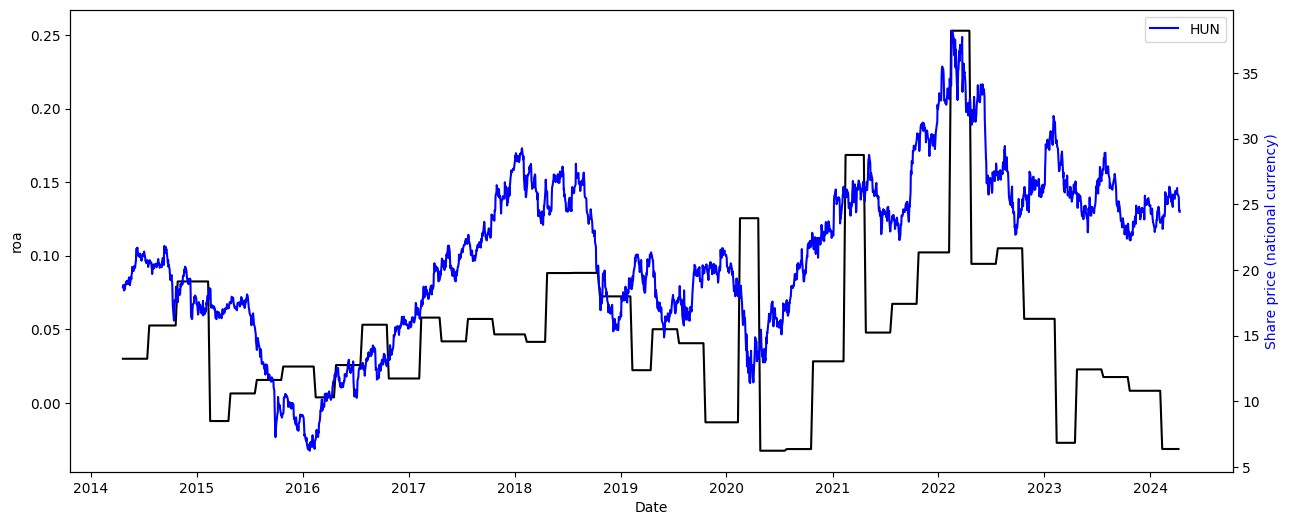

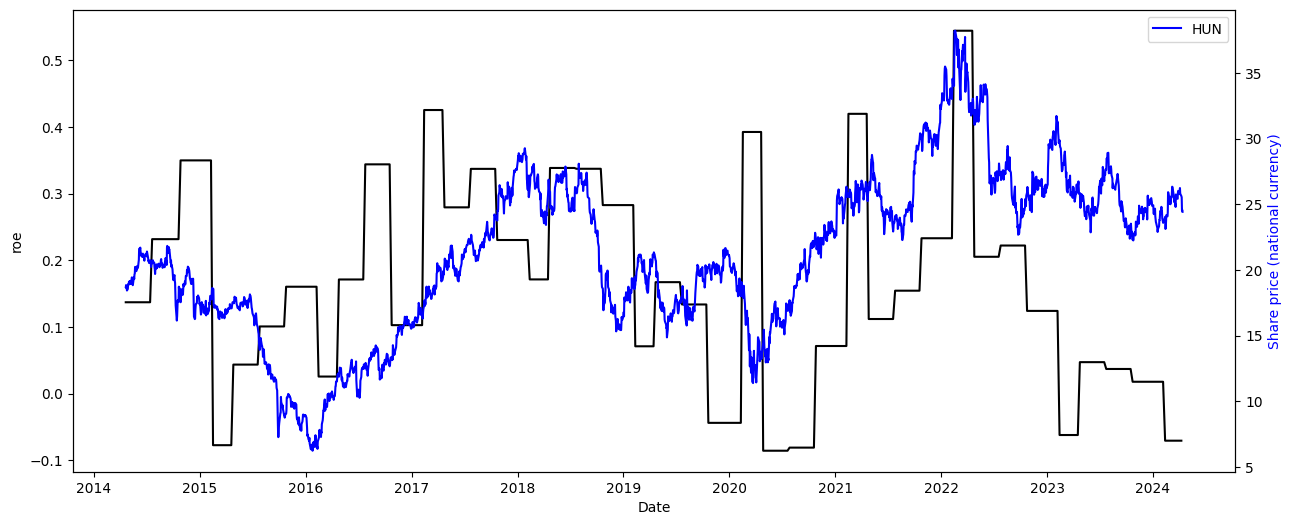

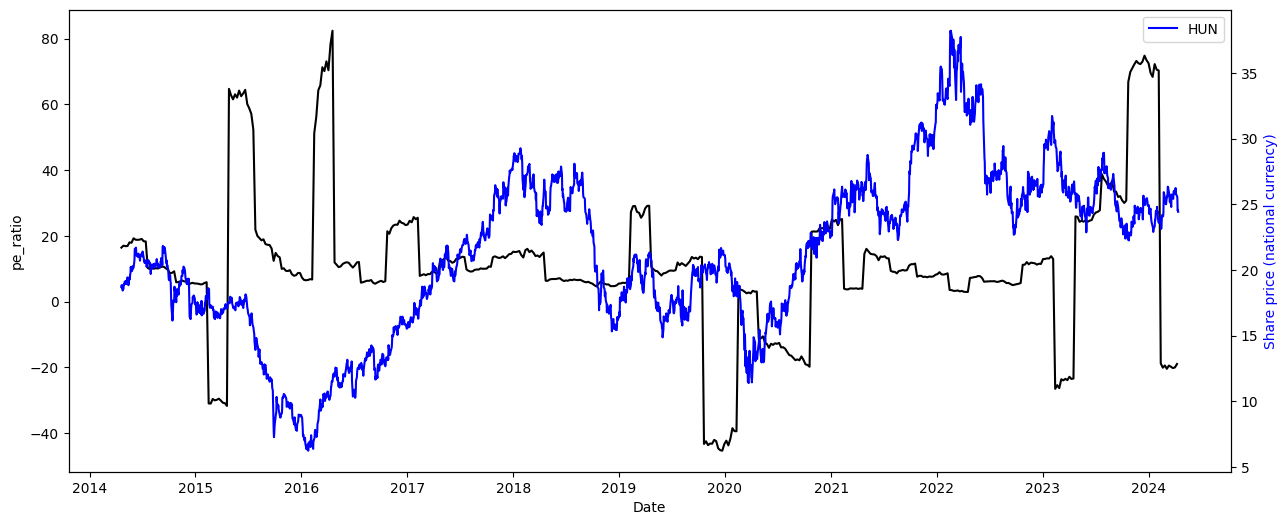

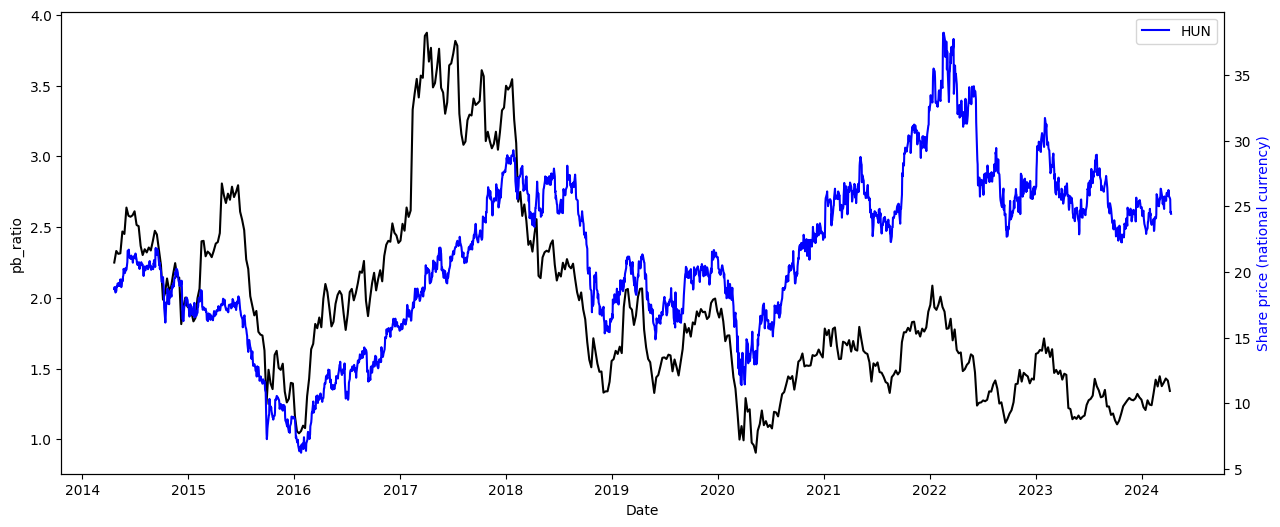

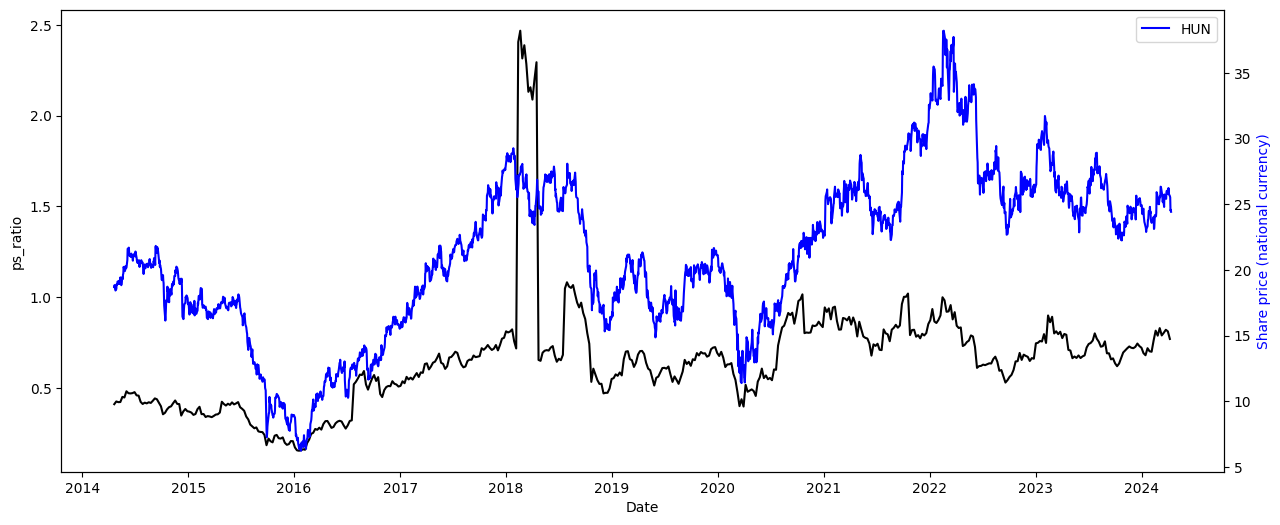

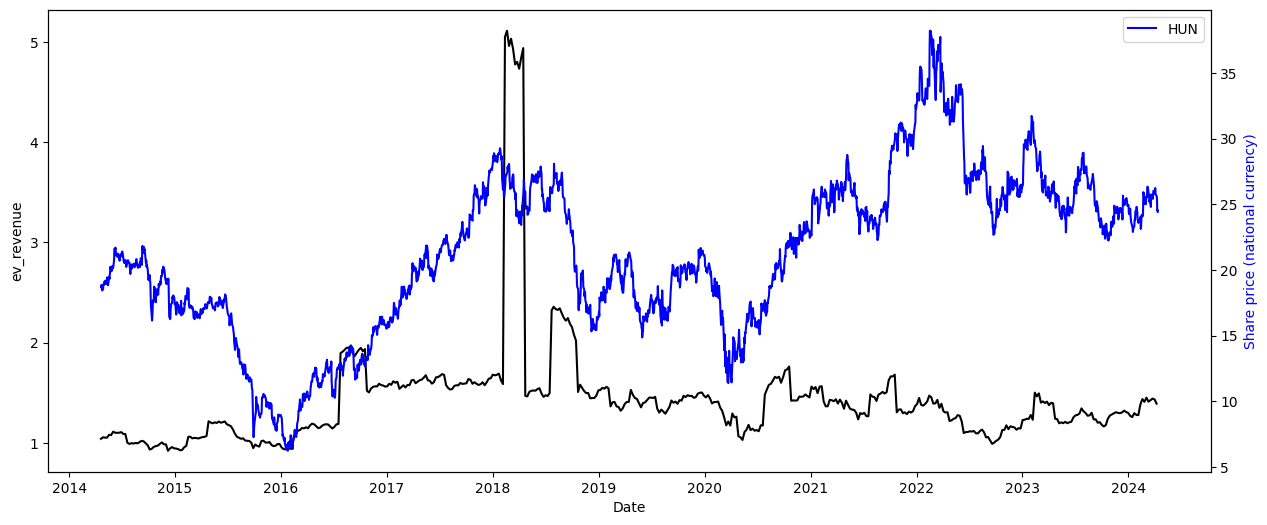

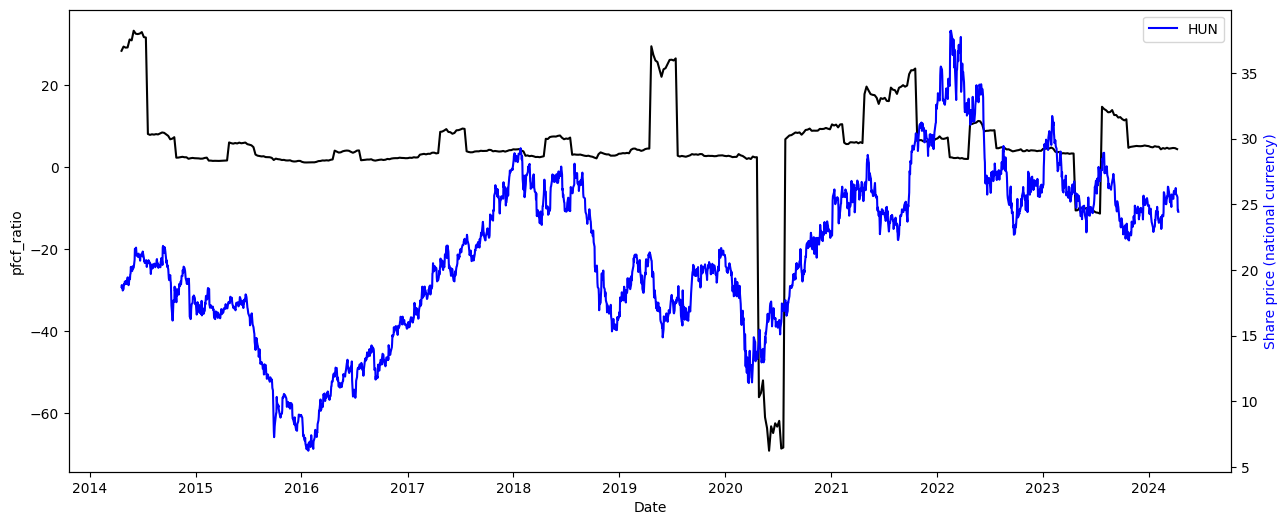

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

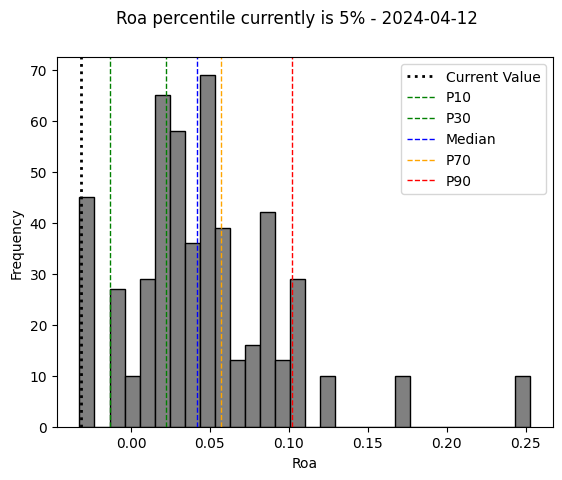

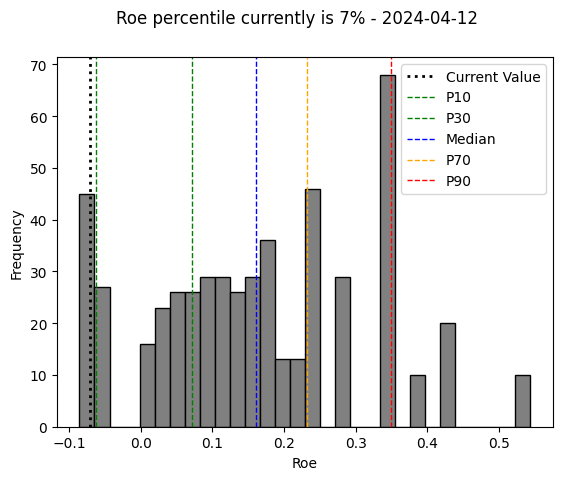

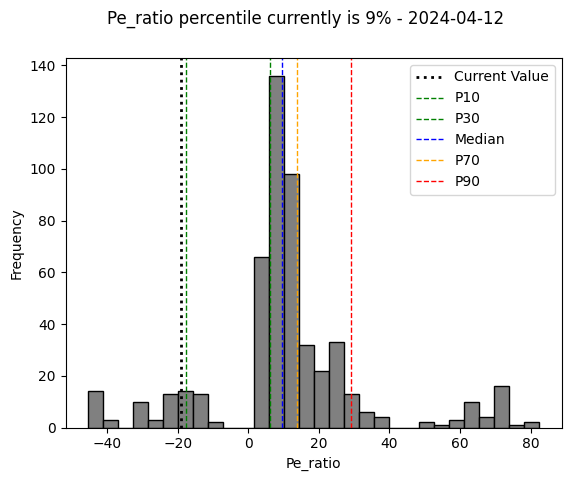

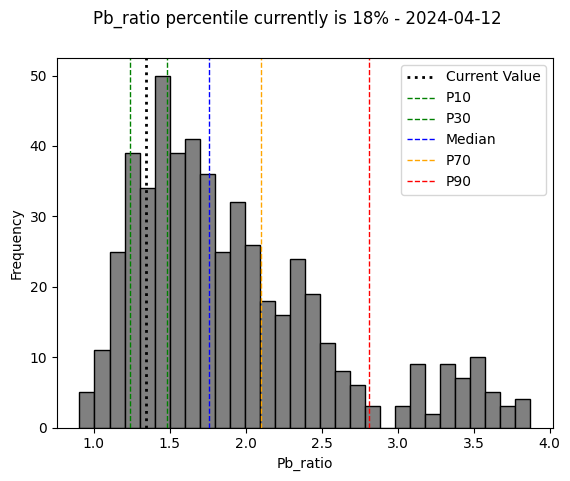

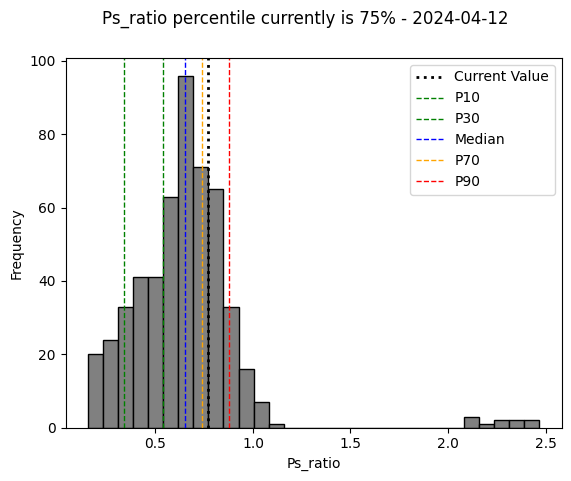

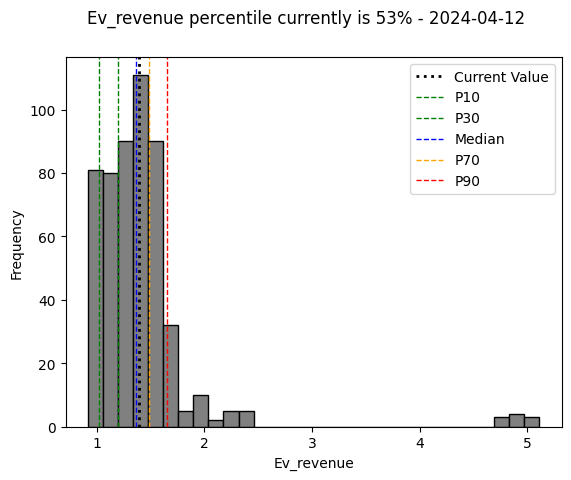

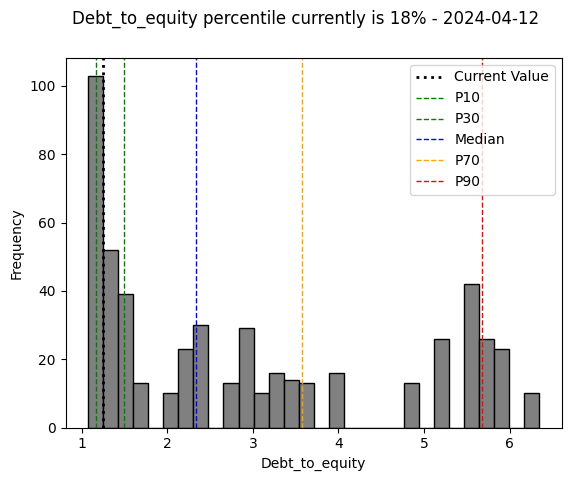

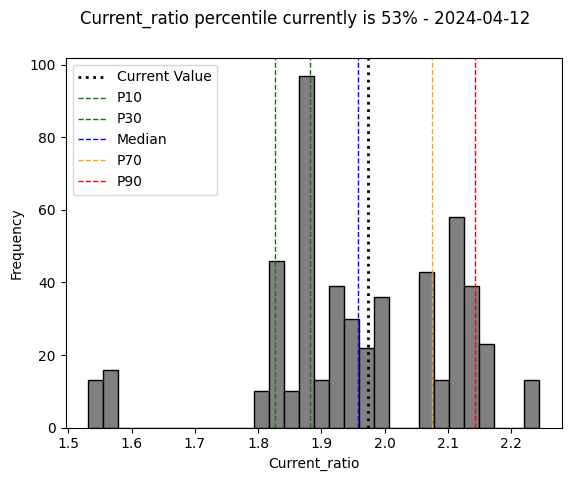

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.861839,0.016403,0.032718,0.152859,0.033531,-0.201508,-0.045587
roe,0.861839,1.000000,0.027412,0.351884,0.041200,0.123146,0.173695,0.120977
pe_ratio,0.016403,0.027412,1.000000,0.052516,-0.086001,-0.039927,0.158456,0.012076
pb_ratio,0.032718,0.351884,0.052516,1.000000,0.075947,0.277172,0.634509,0.161099
ps_ratio,0.152859,0.041200,-0.086001,0.075947,1.000000,0.858195,-0.428434,-0.456429
ev_revenue,0.033531,0.123146,-0.039927,0.277172,0.858195,1.000000,0.022677,-0.232692
debt_to_equity,-0.201508,0.173695,0.158456,0.634509,-0.428434,0.022677,1.000000,0.471447
current_ratio,-0.045587,0.120977,0.012076,0.161099,-0.456429,-0.232692,0.471447,1.000000


0 timestemos have been found!


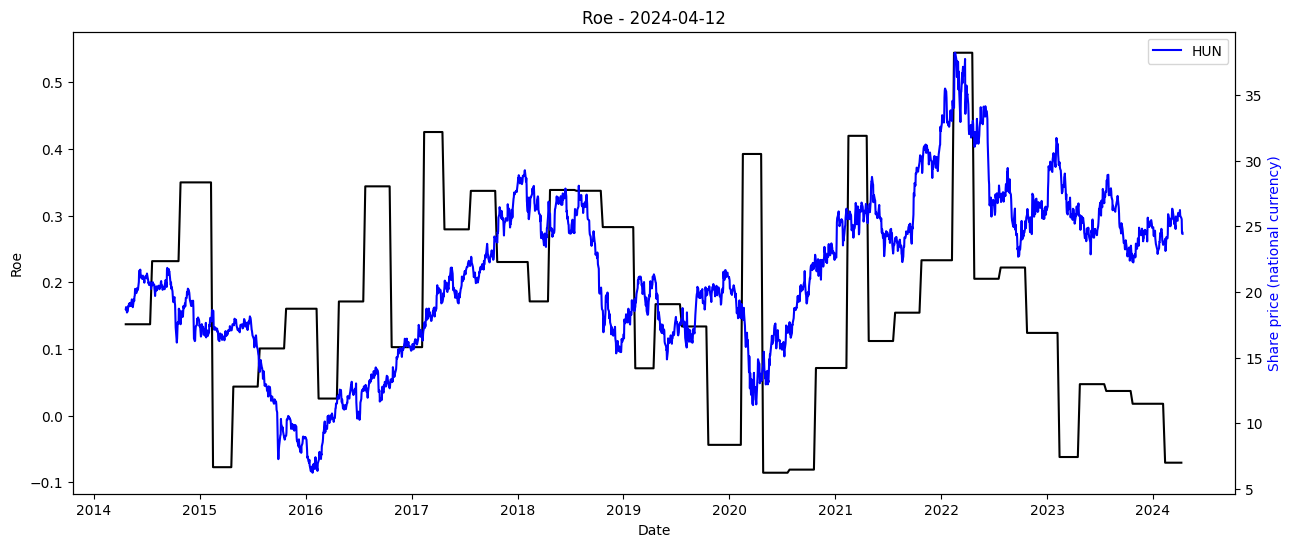

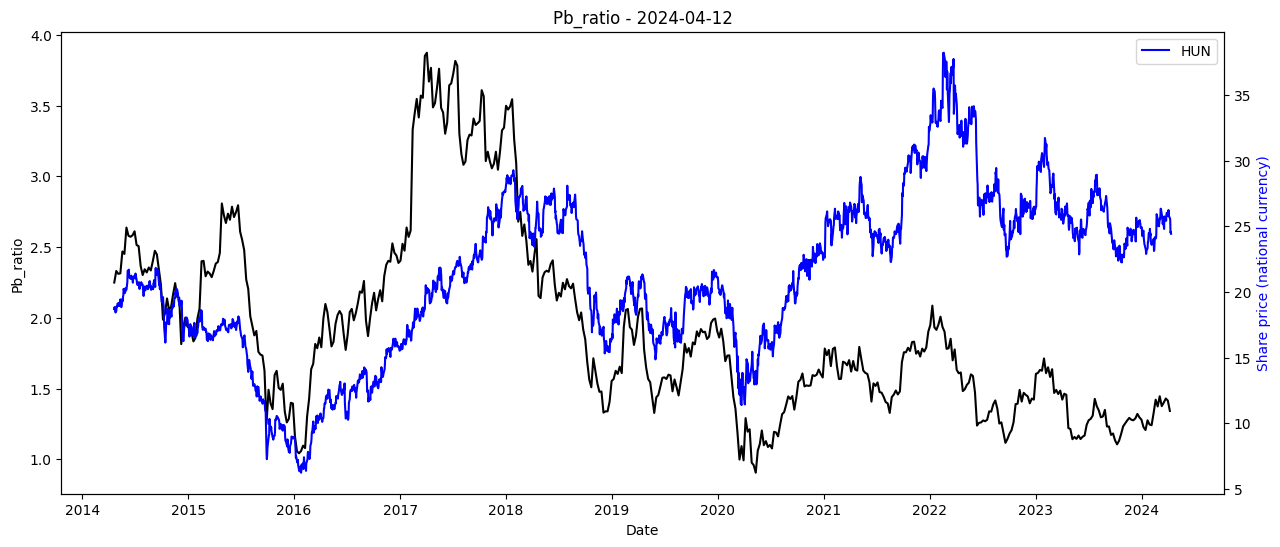

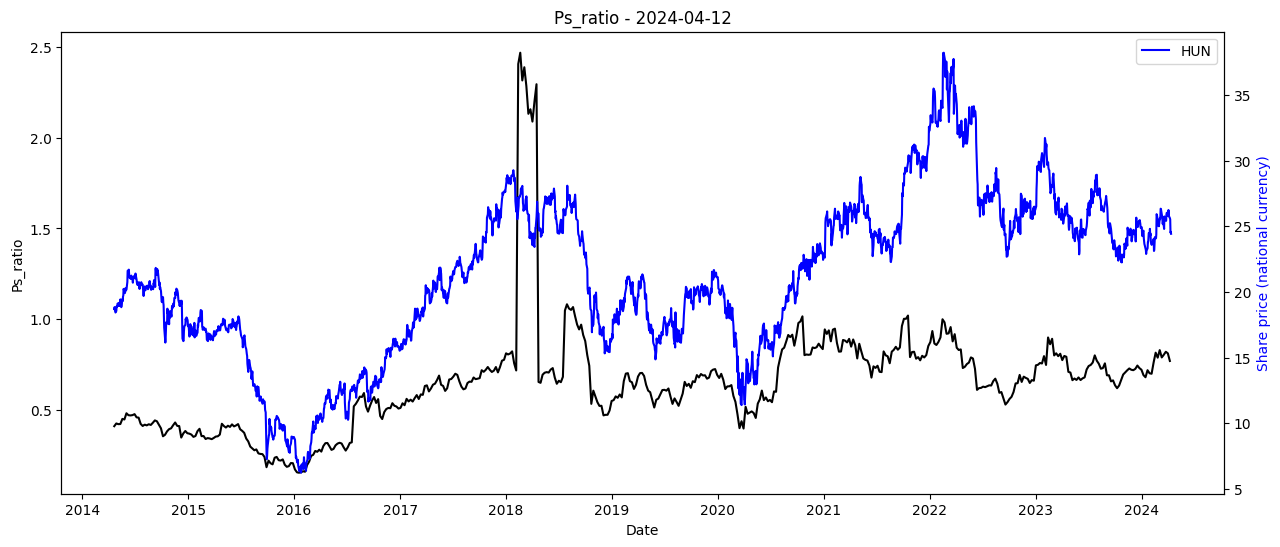

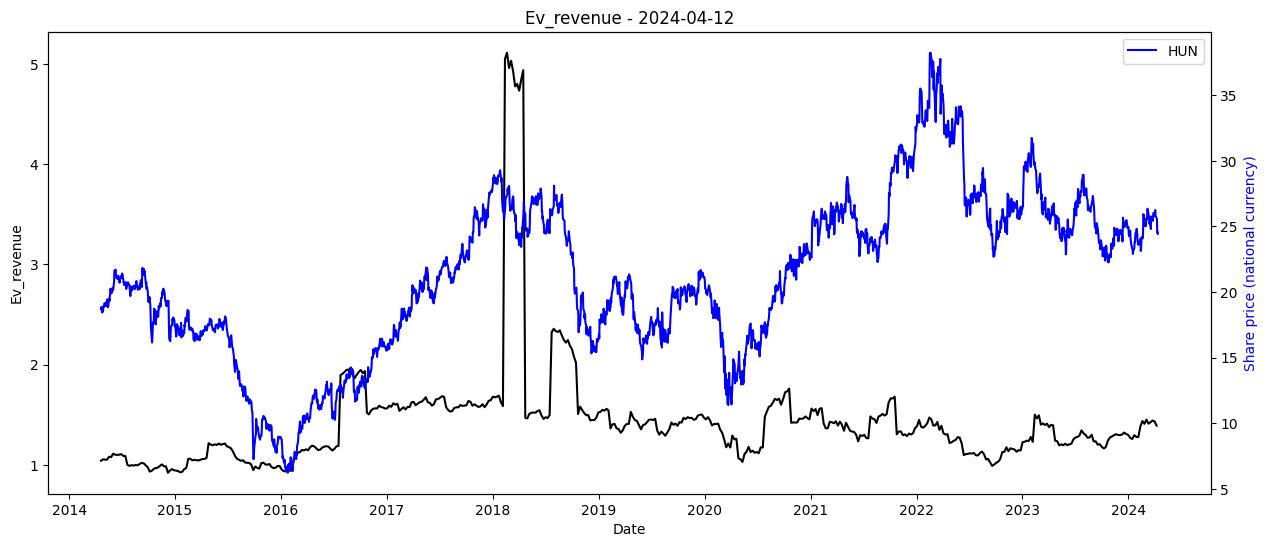

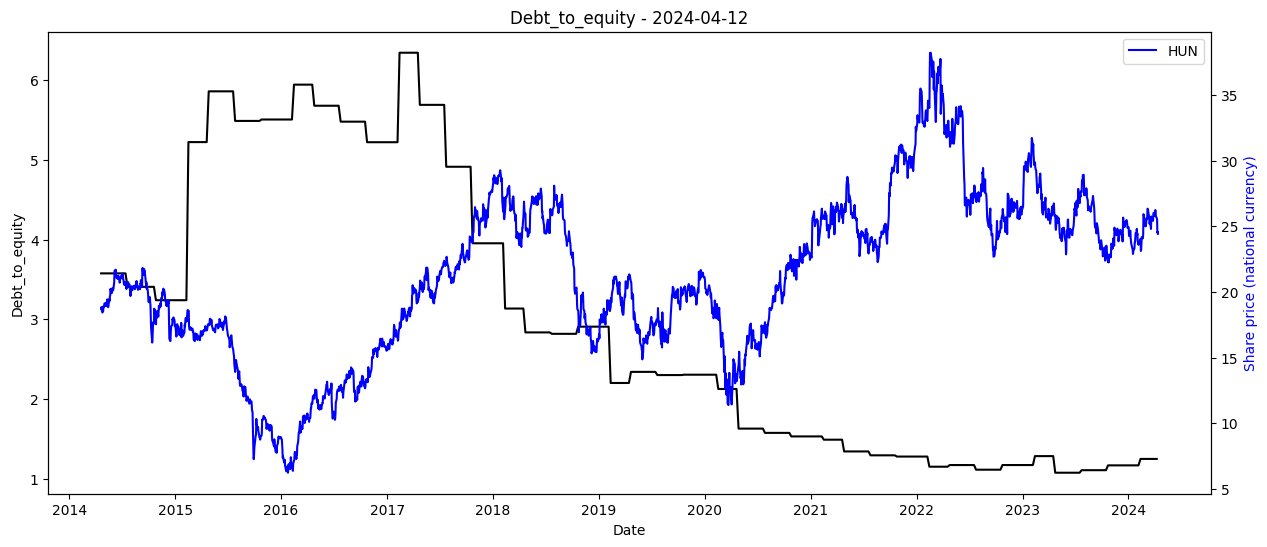

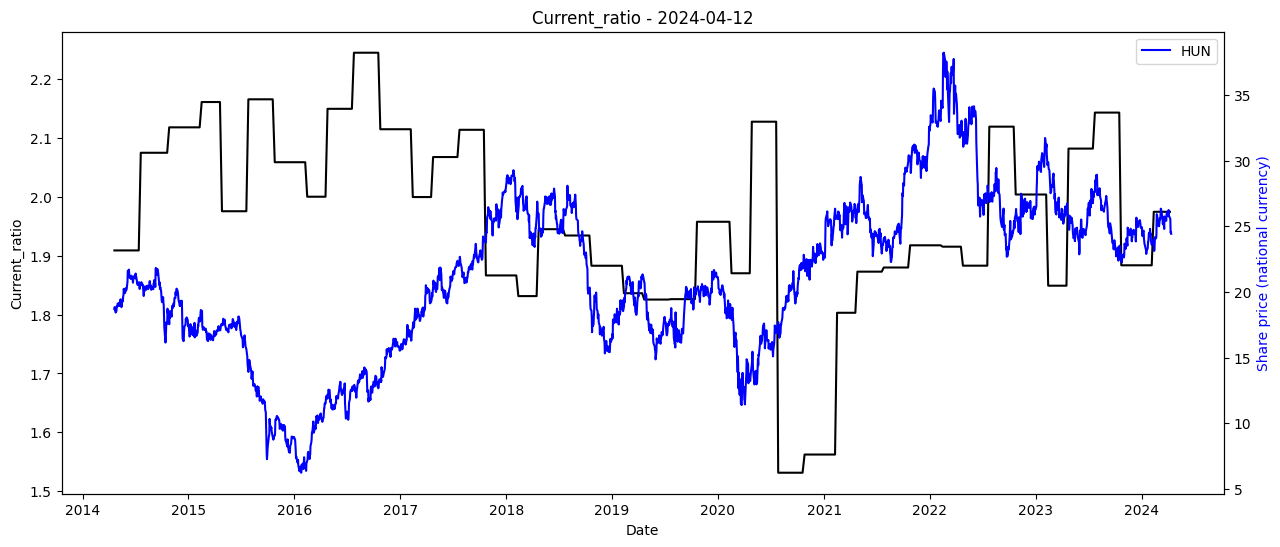

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )